# Electricty Forecast
### Optimal Deep Learning LSTM Model for Electric Load Forecasting using Feature Selection and Genetic Algorithm: Comparison with Machine Learning Approaches

* Salah Bouktif
* Ali Fiaz
* Ali Ouni
* M. Adel Serhani

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
%matplotlib inline

import IPython.core.display as di
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

## Dataset of Average Power Consumption (MW) per 30-minute interval in France. 

In [8]:
df=pd.read_csv('FranceElec.csv', delimiter=';')
print('No. of rows and columns:', df.shape)
df.head(5)

No. of rows and columns: (173856, 5)


,Date - Heure,Date,Hour,Consumption,Quality
0,2009-06-05T21:00:00-07:00,2009-06-06,06:00,35984,Définitive
1,2009-06-06T00:00:00-07:00,2009-06-06,09:00,43188,Définitive
2,2009-06-06T02:30:00-07:00,2009-06-06,11:30,46959,Définitive
3,2009-06-06T03:30:00-07:00,2009-06-06,12:30,48622,Définitive
4,2009-06-06T11:30:00-07:00,2009-06-06,20:30,42578,Définitive


In [9]:
df.Quality.unique()

array(['Définitive', 'Intermédiaire'], dtype=object)

In [10]:
df.dtypes

Date - Heure    object
Date            object
Hour            object
Consumption      int64
Quality         object
dtype: object

### Check Missing Values

In [11]:
df.isnull().sum()

Date - Heure    0
Date            0
Hour            0
Consumption     0
Quality         0
dtype: int64

No missing Values in the dataset

#### Convert Time into Date Time Index and Create Year, Quarter, Month and Day

In [12]:
df['Time']=pd.to_datetime(df['Date - Heure']) 
#DatetimeIndex, which is a pandas index that is optimized to index data with dates and times.
df['year'] = df['Time'].apply(lambda x: x.year)
df['quarter'] = df['Time'].apply(lambda x: x.quarter)
df['month'] = df['Time'].apply(lambda x: x.month)
df['day'] = df['Time'].apply(lambda x: x.day)

In [13]:
df=df[df.Quality=='Définitive']
df=df[(df.year>2007) & (df.year<2017)]
df=df.loc[:,['Time','Consumption', 'year','quarter','month','day']]
df.sort_values('Time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["Time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print(df.shape)
print(df.Time.min())
print(df.Time.max())
df.tail(3)

(157822, 7)
2008-01-01 00:00:00
2016-12-31 22:30:00


,Time,Consumption,year,quarter,month,day,weekday
157819,2016-12-31 21:30:00,71924,2016,4,12,31,0
157820,2016-12-31 22:00:00,75424,2016,4,12,31,0
157821,2016-12-31 22:30:00,75504,2016,4,12,31,0


2008 is a leap year, so there are 366 days in the year.

## Remove Duplicates

In [19]:
#print(df[df.duplicated()].count()['Time'])
#df.drop_duplicates('Time', keep=False, inplace=True)
#df.shape

## Basics Statistics

In [14]:
df.head(3)

,Time,Consumption,year,quarter,month,day,weekday
0,2008-01-01 00:00:00,63949,2008,1,1,1,1
1,2008-01-01 00:30:00,64198,2008,1,1,1,1
2,2008-01-01 01:00:00,64190,2008,1,1,1,1


### Distribution and Normality Test

count   157822.00
mean     55218.38
std      12101.42
min      29477.00
25%      46002.00
50%      53688.00
75%      63558.75
max     101866.00
Name: Consumption, dtype: float64
Kurtosis of normal distribution (should be 0): -0.3529417108831727
Skewness of normal distribution (should be 0): 0.46731018121424756


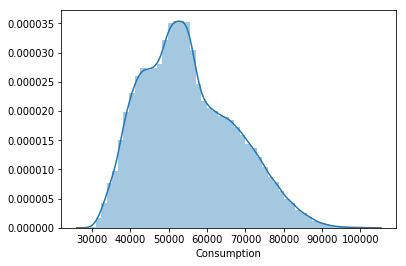

In [15]:
print(df.Consumption.describe())

sns.distplot(df.Consumption);

stats.normaltest(df.Consumption)
#This function tests the null hypothesis that a sample comes from a normal distribution. 
# It is based on D'Agostino and Pearson's test that combines skew and kurtosis to produce
# an omnibus test of normality.
print( 'Kurtosis of normal distribution (should be 0): {}'.format(stats.kurtosis(df.Consumption)))
print( 'Skewness of normal distribution (should be 0): {}'.format(stats.skew(df.Consumption)))

KURTOSIS: describes heaviness of the tails of a distribution

Normal Distribution has a kurtosis of 0 (mesokurtic)
A positive value tells you that you have heavy-tails (i.e. a lot of data in your tails).
A negative value means that you have light-tails (i.e. little data in your tails).

SKEWNESS:

If skewness is less than -1 or greater than 1, the distribution is highly skewed.
If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

## Time Series Plot

In [16]:
df1=df.loc[:,['Time','Consumption']]
#df1['Time'] = df['Time'].apply(lambda x: x.date())
#df1['Time']=pd.to_datetime(df1['Time'])
df1.set_index('Time',inplace=True);

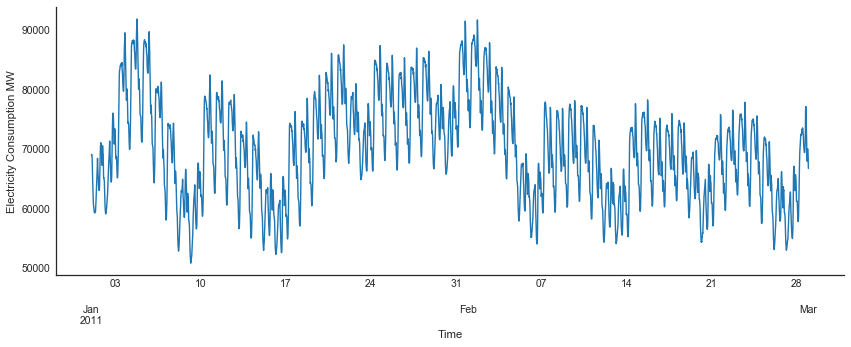

In [17]:
df2=df1[(df1.index>='2011-01-01') & (df1.index<'2011-03-01')]
#a=plt.figure(figsize=(15,6))
#sns.set_style("whitegrid", {'axes.grid' : False});
sns.set_style('white')
sns.set_context("paper", font_scale=1.3)  
#a = fig.gca()  

df2.plot(figsize=(12,5));
#plt.tick_params(left=False, labelleft=True) #remove ticks
#plt.box(False)
plt.ylabel('Electricity Consumption MW')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.savefig('Fig5.png', dpi=400) 
plt.show()

In [18]:
q = df["Consumption"].quantile(0.97)
dfq=df[df["Consumption"] < q]

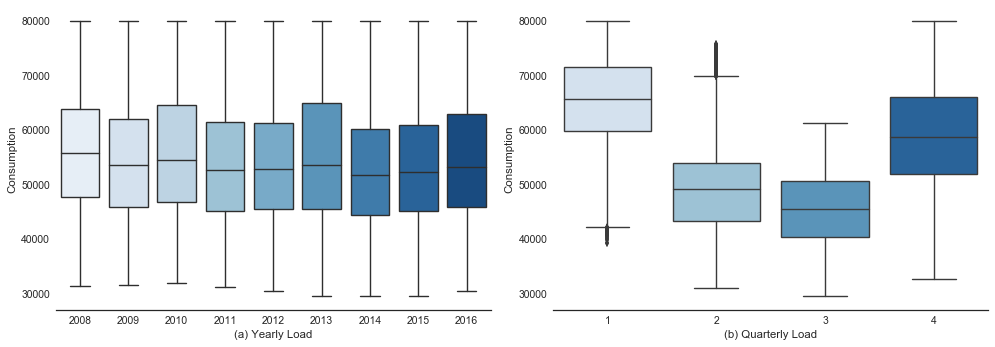

In [19]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.3)  
a=plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Consumption", data=dfq, palette='Blues');
plt.xlabel('(a) Yearly Load')
sns.despine(left=True);
plt.tight_layout() 

plt.subplot(1,2,2)

sns.boxplot(x="quarter", y="Consumption", data=dfq, palette='Blues');
plt.xlabel('(b) Quarterly Load')
sns.despine(left=True);
plt.tight_layout() 

#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
plt.savefig('Fig2.png', dpi=300)

## Electricty Consumption Distribution

,count,mean,std,min,25%,50%,75%,max
Consumption,157822.00,55218.38,12101.42,29477.00,46002.00,53688.00,63558.75,101866.00


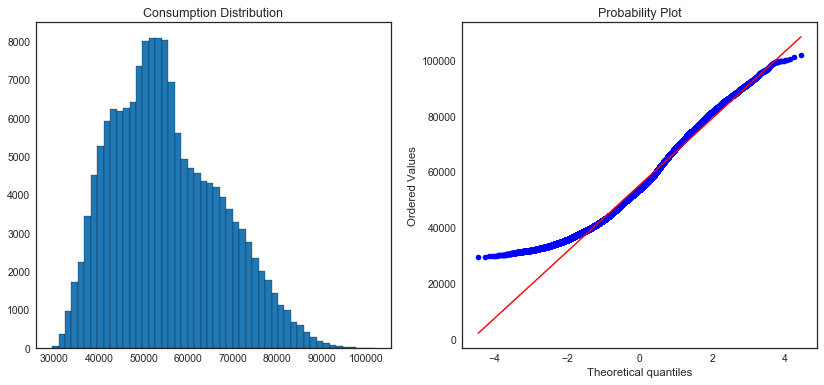

In [20]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Consumption'].hist(bins=50,edgecolor='black', grid=False)
plt.title('Consumption Distribution')

plt.subplot(1,2,2)
stats.probplot(df['Consumption'], plot=plt);
#print("Skewness: %f" % df['Consumption'].skew())
#print("Kurtosis: %f" % df['Consumption'].kurt())
df1.describe().transpose()

Normal probability plot shows the data set is approximately normally distributed. 

### Consumption by Year, Quarter, Month and Day

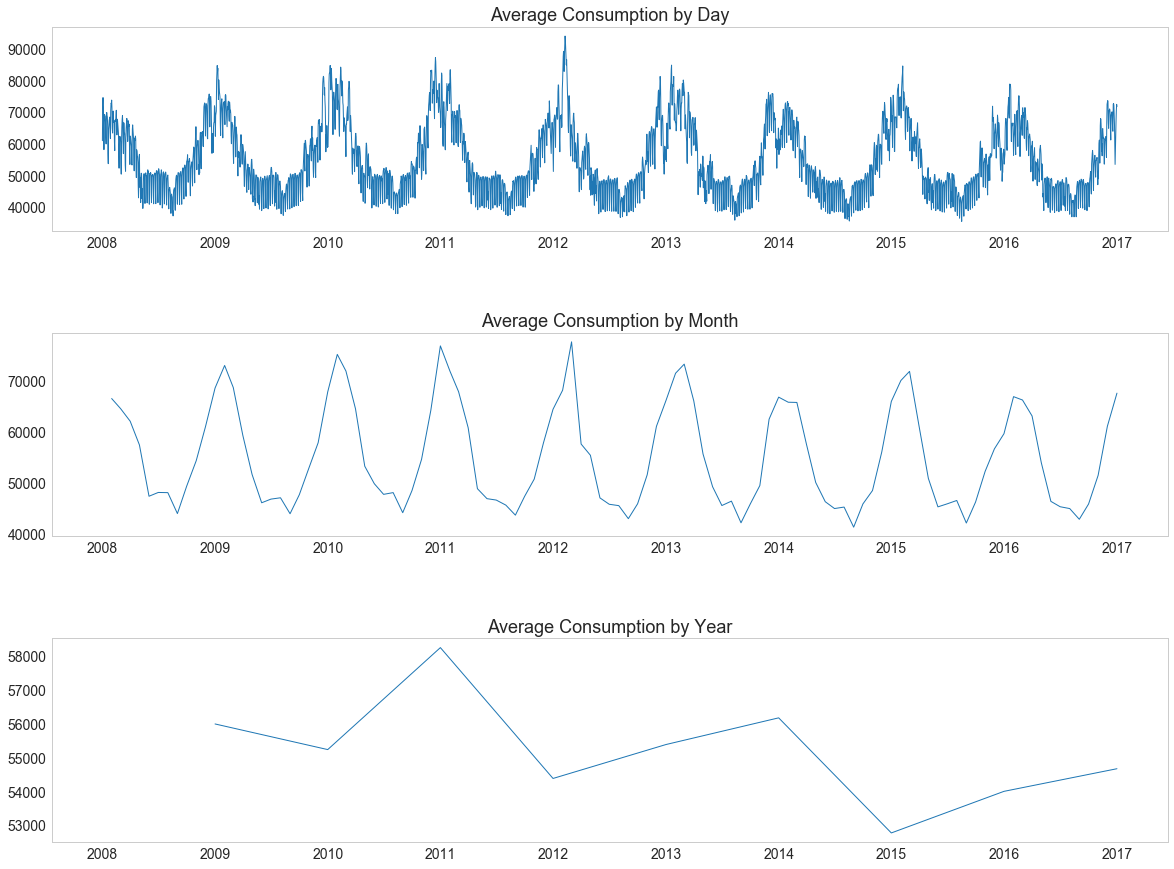

In [25]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=.5)
ax1 = fig.add_subplot(3,1,1)
ax1.plot(df1['Consumption'].resample('D').mean(),linewidth=1)
ax1.set_title('Average Consumption by Day', fontsize=18)
#ax1.set_ylabel('Average Consumption', fontsize=14)
#ax1.set_xlabel('Day of Crime', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2 = fig.add_subplot(3,1,2, sharex=ax1)
ax2.plot(df1['Consumption'].resample('M').mean(),linewidth=1)
ax2.set_title('Average Consumption by Month', fontsize=18)
#ax2.set_ylabel('# of Crimes', fontsize=14)
#ax2.set_xlabel('Month of Crime', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

ax3  = fig.add_subplot(3,1,3, sharex=ax1)
ax3.plot(df1['Consumption'].resample('A').mean(),linewidth=1)
ax3.set_title('Average Consumption by Year', fontsize=18)
#ax3.set_ylabel('# of Crimes', fontsize=14)
#ax3.set_xlabel('Year of Crime', fontsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)

The time series has no general trend,upward or downward. The regression or trend line can then not be used as a prediction of the long run movement of the time series. 

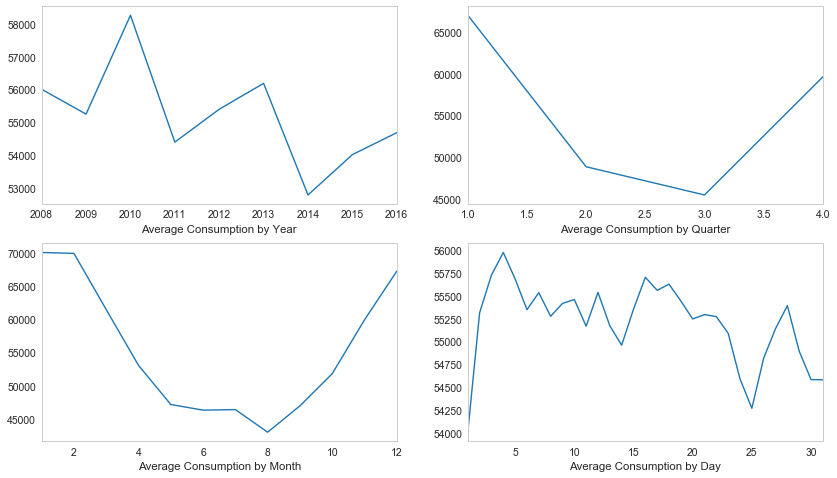

In [26]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Consumption.agg('mean').plot();
plt.xlabel('Average Consumption by Year')

plt.subplot(2,2,2)
df.groupby('quarter').Consumption.agg('mean').plot();
plt.xlabel('Average Consumption by Quarter')

plt.subplot(2,2,3)
df.groupby('month').Consumption.agg('mean').plot();
plt.xlabel('Average Consumption by Month')

plt.subplot(2,2,4)
df.groupby('day').Consumption.agg('mean').plot();
plt.xlabel('Average Consumption by Day');

## Consumption by Years (2008-2016)

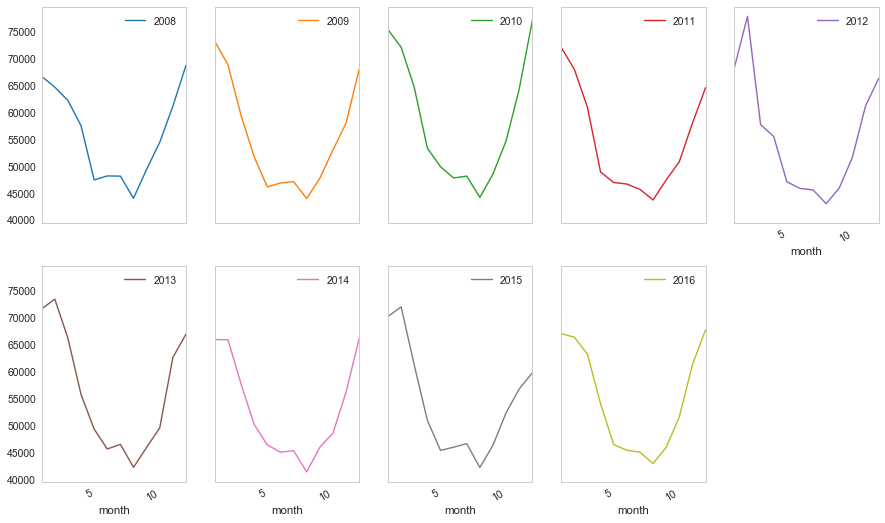

In [27]:
dfPivot = pd.pivot_table(df, values = "Consumption", 
                             columns = "year", index = "month")

dfPivot.plot(subplots = True, figsize=(15, 15), layout=(3, 5), sharey=True);

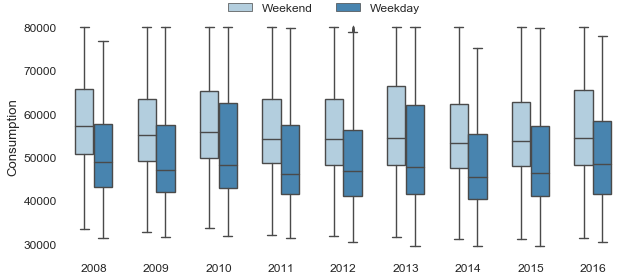

In [29]:
q = df["Consumption"].quantile(0.97)
dfq=df[df["Consumption"] < q]

dic={0:'Weekday',1:'Weekend'}
dfq['Day'] = dfq.weekday.map(dic)

a=plt.figure(figsize=(9,4))
sns.set_context("paper", font_scale=1.5)  
plt1=sns.boxplot('year','Consumption',hue='Day',width=0.6,fliersize=3,
                    data=dfq, palette='Blues');                                                                                                                                                                                                                                                                                                                                             
#plt.title('Box Plot of Consumption by Weekend/Weekday')    
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False)
plt.savefig('Fig3.png', dpi=300)

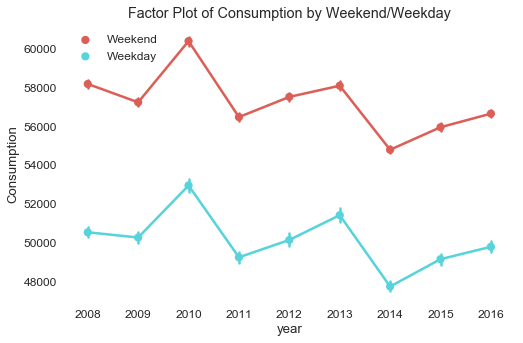

In [21]:
dic={0:'Weekday',1:'Weekend'}
df['Day'] = df.weekday.map(dic)

sns.set_context("paper", font_scale=1.5)  
plt1=sns.factorplot('year','Consumption',hue='Day',
                    data=df, size=5,palette='hls', aspect=1.5, legend=False);                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Consumption by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper left');

** ANALYSIS**

Untrendted Seasonal Time Series

##  Dickey-Fuller Test to Ceck Stationarity

Stationary series has constant mean and variance over time. Rolling average and the rolling standard deviation of time series do not change over time. 

### Dickey-Fuller test

Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [22]:
df2=df1.resample('D', how=np.mean)

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=30)
    rolstd = pd.rolling_std(timeseries, window=30)

    #Plot rolling statistics:
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

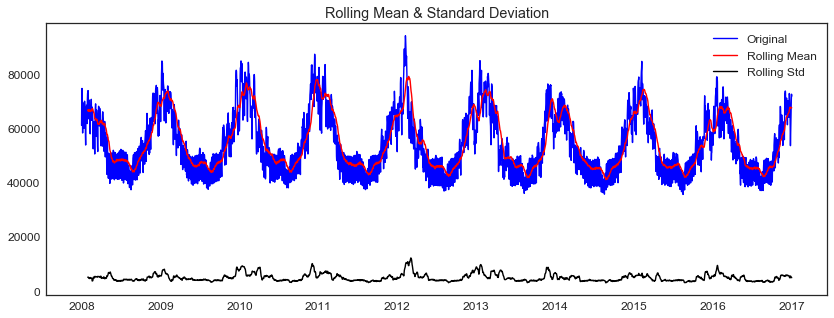

<Results of Dickey-Fuller Test>
Test Statistic                  -4.20
p-value                          0.00
#Lags Used                      28.00
Number of Observations Used   3259.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [23]:
test_stationarity(df2.Consumption)

Reject the null hypothesis H0, the data does not have a unit root and is stationary.
Our data is now below our 10% critical value, but can be further improved.

The test results comprise of a test statistic and some critical values for different confidence levels. If the 'test statistic’ is less than the ‘critical value’, we can reject the null hypothesis and say that the series is stationary.

## Checking Autocorrelation
A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, ACF, correlogram or an autocorrelation plot.

In [37]:
x= df.Consumption
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range =(0 , 1))
x = np. array (x). reshape (( len(x), ))
x=np.log (x)
print (x.shape)#x is a 1 dimensional array with 157786 rows
x=x.reshape(-1 ,1)
print (x.shape)
x = scaler.fit_transform(x)
x=x.reshape (-1)
print (x.shape)
print(round(x.min(),2))
print(round(x.max(),2))
from statsmodels.tsa.stattools import pacf
x_pacf=pacf (x,nlags=20, method='ols')
print (x_pacf)

(157822,)
(157822, 1)
(157822,)
0.0
1.0
[ 1.          0.99372994 -0.70352526  0.02278956  0.13055916  0.05502134
 -0.12037707  0.01453612  0.06895437  0.08343756  0.05203157  0.00936458
  0.15236653  0.06942749 -0.09254955  0.08354328  0.07489388  0.14699984
 -0.07131212  0.12147468 -0.07353598]


## Log Transformation and First Difference

In [40]:
#df2 = df1['Consumption'].resample('D').mean().to_frame()
tslog=np.log(df1)
#tslog = tslog - tslog.shift(1)
#tslog=tslog+10
tslog.dropna(inplace=True)
tslog[tslog.Consumption<0].count()

Consumption    0
dtype: int64

Post Dickey-Fuller Test 

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Perform Dickey-Fuller test:
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#df1diff.head()
tslog.dropna(inplace=True)
test_stationarity(tslog.Consumption)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(tslog.iloc[13:], lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(tslog.iloc[13:], lags=100, ax=ax2)

# Weather Data

In [9]:
dfw=pd.read_csv('weatherFrance.csv')
dfw.head()
print(dfw.shape)

(179481, 4)


In [10]:
list_df=[]
dfw["Time"]=pd.to_datetime(dfw["Time"])
dfw["wind_speed"]=pd.to_numeric(dfw["wind_speed"],errors="coerce")
dfw=dfw[(dfw["wind_speed"]<200) & (dfw["wind_speed"]>0)]
dfw=dfw[(dfw["temperature"]>-20) & (dfw["temperature"]<50)]
dfw=dfw[(dfw["humidity"]>0) & (dfw["humidity"]<100)]

dfw=dfw[["Time","temperature","humidity","wind_speed"]].set_index(["Time"])
for param in ["temperature","humidity","wind_speed"]:
    print(param)
    list_df.append(dfw[[param]].resample('30T').interpolate(method='linear'))
dfw=pd.concat(list_df,axis=1).reset_index()
dfw.set_index ('Time', inplace=True)
dfw.head()

temperature
humidity
wind_speed


,temperature,humidity,wind_speed
Time,,,
2007-06-06 14:30:00,22.97,62.56,17.07
2007-06-06 15:00:00,22.87,63.82,17.17
2007-06-06 15:30:00,22.47,64.95,17.16
2007-06-06 16:00:00,22.19,67.34,16.84
2007-06-06 16:30:00,22.17,67.24,16.93


In [11]:
df0=df.loc[:,['Time','Consumption','quarter', 'month','day','weekday']]
df0.set_index('Time', inplace=True)
df0.head(2)

,Consumption,quarter,month,day,weekday
Time,,,,,
2008-01-01 00:00:00,63949,1,1,1,1
2008-01-01 00:30:00,64198,1,1,1,1


In [121]:
dfp=dfw.join(df0,how='inner')[['Consumption','quarter', 'month', 'day', 'weekday',"temperature",'humidity','wind_speed']]

#dfp=dfp.resample('W', how=np.mean)
#df = df.rename(columns={'temperature': 'Temperature', 'humidity': 'Humidity', 'wind_speed':'Wind Speed'})

dfp.columns = ['Consumption', 'Quarter', 'Month', 'Day', 'Weekday', 'Temperature','Humidity','Wind_Speed']
dfp.head()

,Consumption,Quarter,Month,Day,Weekday,Temperature,Humidity,Wind_Speed
Time,,,,,,,,
2008-01-01 00:00:00,63949,1,1,1,1,2.52,88.91,6.74
2008-01-01 00:30:00,64198,1,1,1,1,2.56,89.43,6.40
2008-01-01 01:00:00,64190,1,1,1,1,2.52,89.54,6.88
2008-01-01 01:30:00,64104,1,1,1,1,2.48,90.00,6.75
2008-01-01 02:00:00,62182,1,1,1,1,2.41,89.94,6.97


In [ ]:
dfp=dfw.join(df0,how='inner')[['Consumption','quarter', 'month', 'day', 'weekday',"temperature",'humidity','wind_speed']]

#dfp=dfp.resample('W', how=np.mean)
#df = df.rename(columns={'temperature': 'Temperature', 'humidity': 'Humidity', 'wind_speed':'Wind Speed'})

dfp.columns = ['Consumption', 'Quarter', 'Month', 'Day', 'Weekday', 'Temperature','Humidity','Wind_Speed']
dfp.head()

In [15]:
df1.head()

,Consumption
Time,
2008-01-01 00:00:00,63949
2008-01-01 00:30:00,64198
2008-01-01 01:00:00,64190
2008-01-01 01:30:00,64104
2008-01-01 02:00:00,62182


## Week Resolution Scatter Plot

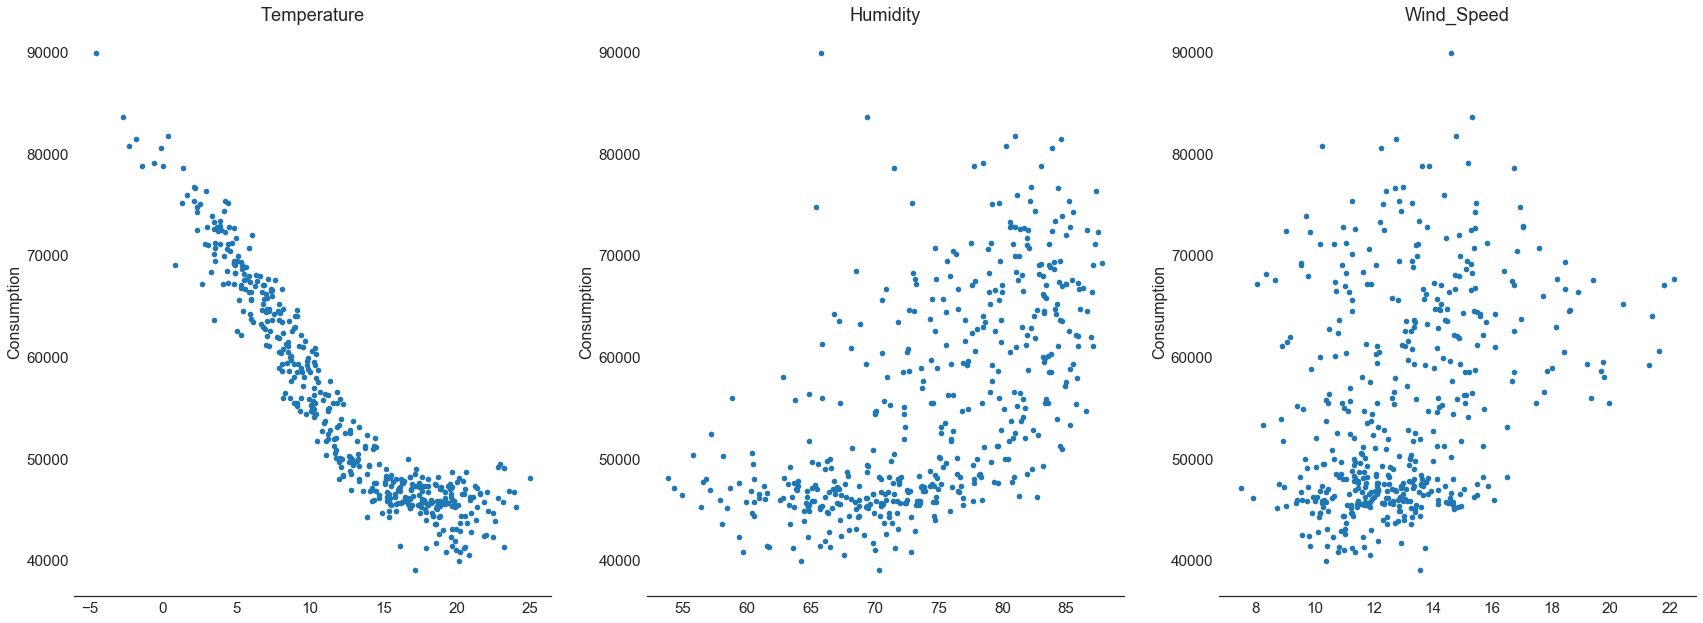

In [74]:
dfweek=dfp.resample('W', how=np.mean)

#Correlation of features with the target Price
Consumption=dfweek.Consumption
features=dfweek.loc[:,['Temperature','Humidity','Wind_Speed']]

sns.set_style('white')
sns.set_context("paper", font_scale=1.9)  
plt.figure(figsize=(24, 9)) #Figure Size with subplots
for i, col in enumerate(features.columns):
    plt.subplot(1, 3, i+1) #Subplot of 1 row and 03 columns
    plt.plot(features[col], Consumption, 'o')
    plt.title(col)
    sns.despine(left=True)
    plt.ylabel('Consumption',fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)

plt.savefig('Fig4.jpeg', dpi=200)

## Checking Correlations

In [81]:
dfc=dfp[['Consumption','Temperature','Humidity','Wind_Speed']]
for obs in range(1,10):
    dfc["T_" + str(obs)] = dfp.Consumption.shift(obs)
dfc.fillna(0.00,inplace=True)
dfc.head()  

,Consumption,Temperature,Humidity,Wind_Speed,T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9
Time,,,,,,,,,,,,,
2008-01-01 00:00:00,63949,2.52,88.91,6.74,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2008-01-01 00:30:00,64198,2.56,89.43,6.40,63949.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2008-01-01 01:00:00,64190,2.52,89.54,6.88,64198.00,63949.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2008-01-01 01:30:00,64104,2.48,90.00,6.75,64190.00,64198.00,63949.00,0.00,0.00,0.00,0.00,0.00,0.00
2008-01-01 02:00:00,62182,2.41,89.94,6.97,64104.00,64190.00,64198.00,63949.00,0.00,0.00,0.00,0.00,0.00


## Correlation Matrix

In [82]:
a=pd.DataFrame(dfc.corr())
a;

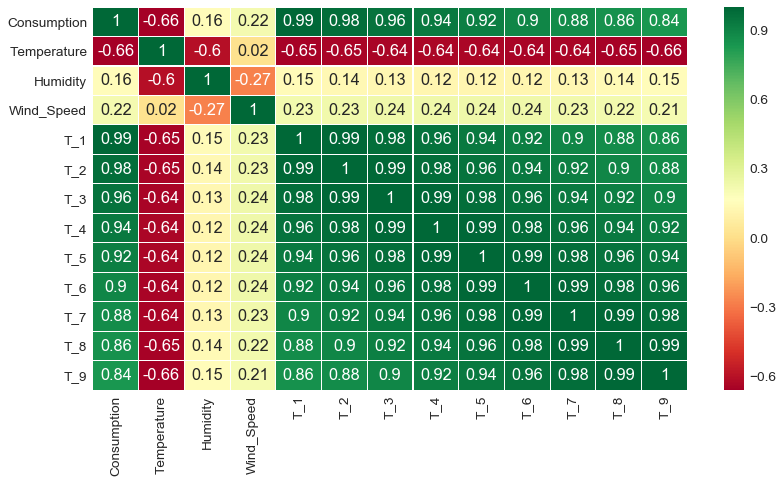

In [83]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.7)  
plt.figure(figsize=(12,7))
sns.heatmap(dfc.corr(), annot=True, cmap='RdYlGn', linewidths=0.1)
plt.tight_layout()

In [85]:
from pandas import ExcelWriter
writer = ExcelWriter('LSTM.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

In [11]:
df.head(2)

,Time,Consumption,year,quarter,month,day,weekday
0,2008-01-01 00:00:00,63949,2008,1,1,1,1
1,2008-01-01 00:30:00,64198,2008,1,1,1,1


## Appending 30 Previous Time Lags

In [122]:
for obs in range(1,31):
    dfp["T_" + str(obs)] = dfp.Consumption.shift(obs)
    
#df.fillna(0.00,inplace=True)
dfp.head(3)  

,Consumption,Quarter,Month,Day,Weekday,Temperature,Humidity,Wind_Speed,T_1,T_2,...,T_21,T_22,T_23,T_24,T_25,T_26,T_27,T_28,T_29,T_30
Time,,,,,,,,,,,,,,,,,,,,,
2008-01-01 00:00:00,63949,1,1,1,1,2.52,88.91,6.74,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-01-01 00:30:00,64198,1,1,1,1,2.56,89.43,6.40,63949.00,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-01-01 01:00:00,64190,1,1,1,1,2.52,89.54,6.88,64198.00,63949.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [123]:
dfp=dfp.dropna()

## Time Lags Only

In [16]:
for obs in range(1,2881):
    df1["T_" + str(obs)] = df1.Consumption.shift(obs)
    
#df.fillna(0.00,inplace=True)
df1.head(3)  

,Consumption,T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9,...,T_2871,T_2872,T_2873,T_2874,T_2875,T_2876,T_2877,T_2878,T_2879,T_2880
Time,,,,,,,,,,,,,,,,,,,,,
2008-01-01 00:00:00,63949,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-01-01 00:30:00,64198,63949.00,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-01-01 01:00:00,64190,64198.00,63949.00,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [18]:
df1=df1.dropna()
df1.shape

(154942, 2881)

In [ ]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

### Min Max Scaling
Transforms features by caling them into range (0,1)

In [41]:
df2=df.loc[:,['Time','Consumption']]
#df1['Time'] = df['Time'].apply(lambda x: x.date())
#df1['Time']=pd.to_datetime(df1['Time'])
df2.set_index('Time',inplace=True);

In [42]:
df2.shape

(157822, 1)

In [27]:
ma = pd.rolling_mean(df2,12)
ma= ma.replace(0,np.NAN)
ma=ma.dropna(how='all',axis=0)
ma.head()

,Consumption
Time,
2008-01-01 05:30:00,60207.92
2008-01-01 06:00:00,59536.08
2008-01-01 06:30:00,58841.58
2008-01-01 07:00:00,58154.83
2008-01-01 07:30:00,57427.83


In [47]:
df2.isnull().sum()

Consumption    0
dtype: int64

In [43]:
df3=df2
df3.head()

,Consumption
Time,
2008-01-01 00:00:00,63949
2008-01-01 00:30:00,64198
2008-01-01 01:00:00,64190
2008-01-01 01:30:00,64104
2008-01-01 02:00:00,62182


In [48]:
# Extract time-lag features for 1 day, 2 day, 3 day, 5 day, 1 week, 2 week, and a month ago
for days_to_lag in [1, 2, 3, 5, 7, 14, 30]:
    df3['Consumption_lag_{}'.format(days_to_lag)] = df3.Consumption.shift(days_to_lag)

In [50]:
df3.isnull().sum()

Consumption            0
Consumption_lag_1      1
Consumption_lag_2      2
Consumption_lag_3      3
Consumption_lag_5      5
Consumption_lag_7      7
Consumption_lag_14    14
Consumption_lag_30    30
dtype: int64

In [51]:
df3.dropna(inplace=True)
df3.shape

(157792, 8)

In [38]:
print(df2.shape)
print(df3.shape)

(157822, 8)
(157822, 8)


In [124]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1,2))
dfp[['Quarter','Month','Day','Temperature','Humidity','Wind_Speed','T_1','T_2','T_3','T_4','T_5','T_6','T_7','T_8','T_9', 'T_10','T_11','T_12','T_13','T_14','T_15','T_16','T_17','T_18','T_19', 'T_20', 'T_21','T_22','T_23','T_24','T_25','T_26','T_27','T_28','T_29', 'T_30']] = scaler.fit_transform(dfp
                                                                                                              [['Quarter','Month','Day','Temperature','Humidity','Wind_Speed',
                                                                                                                'T_1','T_2','T_3','T_4','T_5','T_6','T_7','T_8','T_9', 'T_10','T_11','T_12','T_13','T_14','T_15','T_16','T_17','T_18','T_19','T_20', 'T_21','T_22','T_23','T_24','T_25','T_26','T_27','T_28','T_29', 'T_30']]);

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1,2))
dfp[['Quarter','Month','Day','Temperature','Humidity','Wind_Speed','T_1','T_2','T_3','T_4','T_5','T_6','T_7','T_8','T_9', 'T_10','T_11','T_12','T_13','T_14','T_15','T_16','T_17','T_18','T_19', 'T_20', 'T_21','T_22','T_23','T_24','T_25','T_26','T_27','T_28','T_29', 'T_30']] = scaler.fit_transform(dfp
                                                                                                              [['Quarter','Month','Day','Temperature','Humidity','Wind_Speed',
                                                                                                                'T_1','T_2','T_3','T_4','T_5','T_6','T_7','T_8','T_9', 'T_10','T_11','T_12','T_13','T_14','T_15','T_16','T_17','T_18','T_19','T_20', 'T_21','T_22','T_23','T_24','T_25','T_26','T_27','T_28','T_29', 'T_30']]);

In [125]:
dfp.head(2)

,Consumption,Quarter,Month,Day,Weekday,Temperature,Humidity,Wind_Speed,T_1,T_2,...,T_21,T_22,T_23,T_24,T_25,T_26,T_27,T_28,T_29,T_30
Time,,,,,,,,,,,,,,,,,,,,,
2008-01-01 15:00:00,56636,1.00,1.00,1.00,1,1.32,1.81,1.17,1.38,1.39,...,1.38,1.38,1.39,1.41,1.43,1.45,1.48,1.48,1.48,1.48
2008-01-01 15:30:00,56928,1.00,1.00,1.00,1,1.31,1.82,1.16,1.38,1.38,...,1.37,1.38,1.38,1.39,1.41,1.43,1.45,1.48,1.48,1.48


A seasonal pattern that repeats each kth period of time indicates that you should take the kth difference to remove a portion of the pattern. Most series should not require more than two difference operations or orders.

# Modeling

The difference in mean residuals for every quarter suggests seasonality

## Train Test Split

In [126]:
dfp.index.max()

Timestamp('2016-12-31 22:30:00')

In [127]:
# Define training and testing periods
train_start = '2008-01-01'
train_end = '2014-04-1'
test_start = '2014-04-2'
test_end = '2016-12-31'

In [128]:
# Split up into training and testing sets (still in Pandas dataframes)

X_train = dfp[train_start:train_end]
del X_train['Consumption']

y_train = dfp['Consumption'][train_start:train_end]

X_test = dfp[test_start:test_end]
del X_test['Consumption']

y_test = dfp['Consumption'][test_start:test_end]

In [129]:
print ('Number of observations in the Training set:', len(X_train))
print ('Percentage of data in Training set:', len(X_train)/len(dfp)*100)
print ('Number of observations in the Test set: ', len(X_test))
print ('Percentage of data in Test set:', len(X_test)/len(dfp)*100)

Number of observations in the Training set: 109556
Percentage of data in Training set: 69.43064287162848
Number of observations in the Test set:  48236
Percentage of data in Test set: 30.56935712837153


In [130]:
def MAPError(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((np.abs(y_true - y_pred)) / (y_true)) * 100

## Linear Regression as Benchmark Model

In [131]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [132]:
# Initialize and fit the model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# R^2 (coefficient of determination) regression score function
# Mean squared error regression loss

benchmark_model = LinearRegression() #object of class LinearRegression

start = time()
benchmark_model.fit(X_train, y_train) #Fit object to training set
end = time()
y_pred=benchmark_model.predict(X_test)
print("Classifier fitted in {:.2f} seconds".format(end-start))
print("Score on Training data : {:.2f}%".format(benchmark_model.score(X_train, y_train) * 100))
print("Score on Testing data : {:.2f}%".format(benchmark_model.score(X_test, y_test) * 100))

print("RMSE : {:.3f}".format(np.sqrt(np.mean((y_test - y_pred)**2))))
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %f' % mae)
mape=MAPError(y_test, y_pred)
print('MAPE: %f' % mape)

Classifier fitted in 0.14 seconds
Score on Training data : 99.54%
Score on Testing data : 99.44%
RMSE : 847.131
MAE: 630.887660
MAPE: 1.216846


### Coefficients of the Regression Model

In [133]:
pd.DataFrame(benchmark_model.coef_,X_train.columns,columns=['Coeff'])

,Coeff
Quarter,73.53
Month,-82.10
Day,-1.75
Weekday,180.49
Temperature,-1226.67
Humidity,-314.63
Wind_Speed,170.10
T_1,120763.60
T_2,-46554.93
T_3,-8769.72


## Recursive Feature Elimination

In [134]:
from sklearn import linear_model
from sklearn.feature_selection import RFE

if __name__ == "__main__":
    
    lr = linear_model.LinearRegression()

    rfe = RFE(lr, 10)
    fit = rfe.fit(X_train, y_train)
    print("Features: {features}".format(features=X_train.columns))
    print("Num Features: {number_features}".format(number_features=fit.n_features_))
    print("Selected Features: {support}".format(support=fit.support_))
    print("Feature Ranking: {ranking}".format(ranking=fit.ranking_))

    selected_columns = [column for column, selected in zip(X_train.columns, fit.support_) if selected]
    print("Selected columns: {selected}".format(selected = selected_columns))

Features: Index(['Quarter', 'Month', 'Day', 'Weekday', 'Temperature', 'Humidity',
       'Wind_Speed', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 'T_6', 'T_7', 'T_8',
       'T_9', 'T_10', 'T_11', 'T_12', 'T_13', 'T_14', 'T_15', 'T_16', 'T_17',
       'T_18', 'T_19', 'T_20', 'T_21', 'T_22', 'T_23', 'T_24', 'T_25', 'T_26',
       'T_27', 'T_28', 'T_29', 'T_30'],
      dtype='object')
Num Features: 10
Selected Features: [False False False False False False False  True  True False False False
 False False False False False False False  True  True False  True  True
  True  True False False False False False False False False False  True
  True]
Feature Ranking: [27 26 28 24 21 23 25  1  1  3 15  4  5 19 14 17  6  2 20  1  1 22  1  1  1
  1 16 13 12 18 10  9 11  8  7  1  1]
Selected columns: ['T_1', 'T_2', 'T_13', 'T_14', 'T_16', 'T_17', 'T_18', 'T_19', 'T_29', 'T_30']


## Machine Learning Modeling

1. Ridge Regression
2. k-Nearest Neighbors
3. Random Forest Regressor
4. GradientBoostingRegresso
5. ExtraTreesRegressor
6. Neural Network

In [135]:
# Function to fit the regressor and record performance metrics
def pipeline(reg, X_train, y_train, X_test, y_test, **kwargs):
    
    # Dictionary to hold properties of Models
    reg_props = {}
    
    # Initialize and fit the regressor, and time taken
    regressor = reg(**kwargs)
    start = time()
    regressor.fit(X_train, y_train)
    end = time()
    
    # Store the metrics for the regressor
    reg_props["name"] = reg.__name__
    reg_props["train_time"] = end - start
    reg_props["train_score"] = regressor.score(X_train, y_train)
    reg_props["test_score"] = regressor.score(X_test, y_test)
    reg_props["rmse"] = np.sqrt(mean_squared_error(y_test, regressor.predict(X_test)))
    reg_props["MAE"] = mean_absolute_error(y_test, regressor.predict(X_test))
    reg_props["MAPE"] = MAPError(y_test, regressor.predict(X_test))
    
    return reg_props

In [137]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

# Function to execute each algorithm through the pipeline
def execute_pipeline():
    # Create the list of algorithms
    regressors = [
        Ridge,
        KNeighborsRegressor,
        RandomForestRegressor,
        GradientBoostingRegressor,
        MLPRegressor,
        ExtraTreesRegressor,
            ]
    
    # To store the properties for each regressor
    props = []
    
    """
    Iterate thorugh the list of regressors,
    passing each thorugh the pipeline and
    storing its properites
    """ 
    for reg in regressors:
        properites = pipeline(reg, X_train, y_train, X_test, y_test)
        props.append(properites)
        
    return props

Mean Absolute Deviation MAD: The average of the absolute values of the devition between the actual and forecast. The absolute error is the absolute value of the difference between the forecasted value and the actual value. MAE tells us how big of an error we can expect from the forecast on average.

The MAPE (Mean Absolute Percent Error) measures the size of the error in percentage terms. MAPE allows us to compare forecasts of different series in different scales.

In [138]:
def get_properties():
    # Obtain the properties after executing the pipeline
    properties = execute_pipeline()
    
    # Extract each individual property of the Regressors
    names = [prop["name"] for prop in properties]
    train_times = [prop["train_time"] for prop in properties]
    train_scores = [prop["train_score"] for prop in properties]
    test_scores = [prop["test_score"] for prop in properties]
    rmse_vals = [prop["rmse"] for prop in properties]
    mae_vals = [prop["MAE"] for prop in properties]
    mape_vals=[prop["MAPE"] for prop in properties]
        
    # Create a DataFrame from these properties
    df = pd.DataFrame(index=names, 
                    data = {
                            "Training Times": train_times,
                            "Training Scores": train_scores,
                            "Testing Scores": test_scores,
                            "RMSE": rmse_vals,
                            "MAE":mae_vals,
                            "MAPE":mape_vals
                      }
                  )
    
    return df

# Obain the properties in a structured DataFrame after executing the pipeline
properties = get_properties()

In [139]:
# Append the peoperties of Linear Rgression Benchmark model to the DataFrame
# Storing the properties of Selected models

properties = pd.concat(
    [properties,
    pd.Series(
    {
        "Name": "Linear Regression (Benchmark)",
        "RMSE": np.sqrt(mean_squared_error(y_test, benchmark_model.predict(X_test))),
        "MAE": mean_absolute_error(y_test, benchmark_model.predict(X_test)),
        "MAPE": MAPError(y_test, benchmark_model.predict(X_test)),
        "Training Scores": benchmark_model.score(X_train, y_train),
        "Testing Scores" :benchmark_model.score(X_test, y_test),
        "Training Times": end - start
        
    }
    ).to_frame().T.set_index(["Name"])]
)

properties

,MAE,MAPE,RMSE,Testing Scores,Training Scores,Training Times
Ridge,637.86,1.23,855.75,0.99,1.00,0.09
KNeighborsRegressor,1052.02,2.03,1404.82,0.98,1.00,2.30
RandomForestRegressor,370.66,0.70,540.40,1.00,1.00,27.83
GradientBoostingRegressor,748.57,1.44,1024.94,0.99,0.99,21.48
MLPRegressor,1595.29,3.10,2049.26,0.97,0.97,250.03
ExtraTreesRegressor,321.21,0.61,467.37,1.00,1.00,8.74
Linear Regression (Benchmark),630.89,1.22,847.13,0.99,1.00,0.14


## Performance Plots of Models

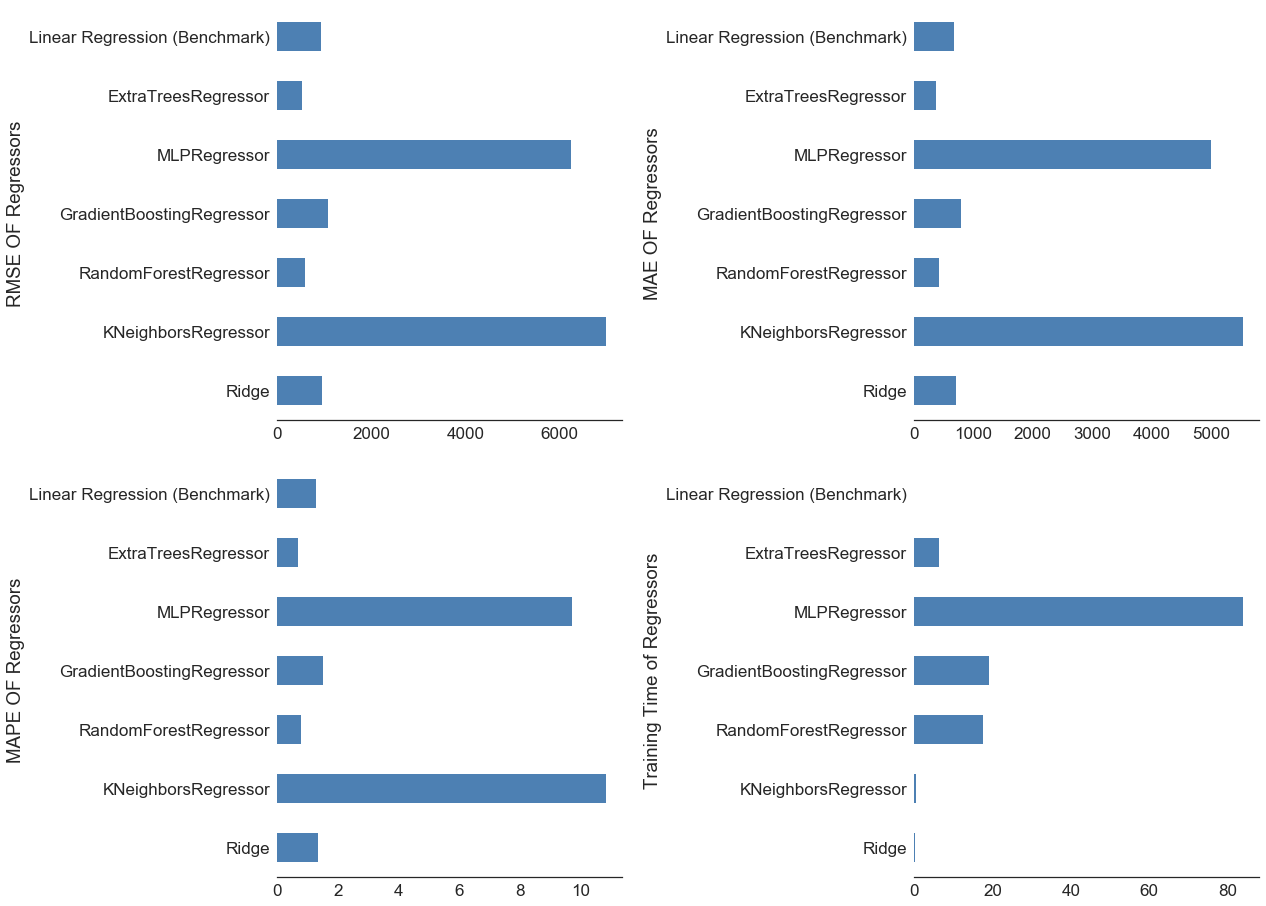

In [141]:
# Plot to compare thePerformance of Algorithms
sns.set_context("notebook", font_scale=1.7)
plt.figure(figsize=(18,13))
plt.subplot(2,2,1)
plt.ylabel("RMSE OF Regressors")
properties["RMSE"].plot(kind="barh", color='#4d80b3');
sns.despine(left=True)
plt.tight_layout()


plt.subplot(2,2,2)
plt.ylabel("MAE OF Regressors")
properties["MAE"].plot(kind="barh", color='#4d80b3');
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,3)
plt.ylabel("MAPE OF Regressors")
properties["MAPE"].plot(kind="barh", color='#4d80b3');
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,4)
plt.ylabel("Training Time of Regressors")
properties["Training Times"].plot(kind="barh", color='#4d80b3');
sns.despine(left=True)
plt.tight_layout()

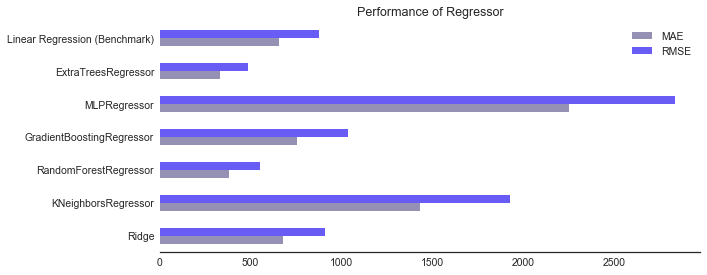

In [308]:
# Plot to compare the performance of Models on both datasets
sns.set_style('white')
sns.set_context("paper", font_scale=1.3)  

ax= properties[["MAE", "RMSE"]].plot(kind="barh", color=['#9491B5', '#685CF4'], title="Performance of Regressor", figsize=(10, 4))
sns.despine(left=True);
plt.tight_layout() 
plt.savefig('book1.png', dpi=300, frameon=False) 
plt.show()

## Hyper Parameter Tuning of Extra Trees Regressor

A Meta Estimator that fits a number of randomized decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting

1. No of Trees
2. No of Features to Consider
3. Max Depth of Tree


In [140]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize the best performing regressor
clf = ExtraTreesRegressor()

# Define the parameter subset
param_grid = {
    "n_estimators": [10, 50, 75, 100, 150],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [50, 100,150, 200, 250]
}

# Use Randomized search to try 20 subsets from parameter space with 5-fold cross validation
grid_search = RandomizedSearchCV(clf, param_grid, n_iter=10, scoring="mean_squared_error", cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.7min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [10, 50, 75, 100, 150], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [50, 100, 150, 200, 250]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='mean_squared_error',
          verbose=2)

In [141]:
#Display best params
print("Parameters of best Regressor : {}".format(grid_search.best_params_))

Parameters of best Regressor : {'n_estimators': 50, 'max_features': 'auto', 'max_depth': 100}


## Forecasting Metrics after Tuning

In [142]:
best_model = grid_search.best_estimator_
print('Mean Absolute Error:', mean_absolute_error(y_test, best_model.predict(X_test)))
print('Mean Squared Error:',np.sqrt(mean_squared_error(y_test, best_model.predict(X_test))))
print('Mean Absolute Percentage Error:',MAPError(y_test, best_model.predict(X_test)))

Mean Absolute Error: 295.797717058
Mean Squared Error: 431.240757219
Mean Absolute Percentage Error: 0.560967048582


### GridSearch CV

In [92]:
from sklearn.grid_search import GridSearchCV
clf = ExtraTreesRegressor()

param_grid = {
    "n_estimators": [10, 50, 75, 100, 150],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [50, 100,150, 200, 250]
}


gs_cv = GridSearchCV(clf, param_grid, scoring="mean_squared_error", cv=3, n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
gs_cv.best_params_

#Display best params
print("Parameters of best Regressor : {}".format(gs_cv.best_params_))

best_model = gs_cv.best_estimator_
print('Mean Absolute Error:', mean_absolute_error(y_test, best_model.predict(X_test)))
print('Mean Squared Error:',np.sqrt(mean_squared_error(y_test, best_model.predict(X_test))))
print('Mean Absolute Percentage Error:',MAPError(y_test, best_model.predict(X_test)))

Parameters of best Regressor : {'max_depth': 200, 'max_features': 'auto', 'n_estimators': 150}
Mean Absolute Error: 292.492209228
Mean Squared Error: 428.01855683
Mean Absolute Percentage Error: 0.555118277739


In [ ]:
#trainPredict1=pd.DataFrame(trainPredict)
#trainY1=pd.DataFrame(trainY)
#trainY1=trainY1.transpose()

testPredict1=pd.DataFrame(best_model.predict(X_test))
testY1=pd.DataFrame(y_test)
testY1=testY1.transpose()

sns.set_style('white')
sns.set_context("paper", font_scale=1.5)  
plt.figure(figsize=(14,6))
plt.plot(y_test[800:1600], label = "Test Data")
plt.plot(testPredict1[800:1600], label = "Test Predict")
plt.legend();

In [184]:
from sklearn.metrics import mean_squared_error

def performance_metric(y_true, y_predict):
    """ Calculates and returns the total error between true and predicted values
        based on a performance metric chosen by the student. """
    

    error = mean_squared_error(y_true, y_predict)
    return error

In [235]:
def learning_curves(X_train, y_train, X_test, y_test):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing error rates for each model are then plotted. """
    
    print ("Creating learning curve graphs for max_depths of 1, 3, 6, and 10. . .")
    
    # Create the figure window
    fig = plt.figure(figsize=(6,4))

    # We will vary the training set size so that we have 50 different sizes
    sizes = np.rint(np.linspace(1, len(X_train), 50)).astype(int)
    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))

    # Create four different models based on max_depth
    for k, depth in enumerate([150]):
        
        for i, s in enumerate(sizes):
            
            # Setup a decision tree regressor so that it learns a tree with max_depth = depth
            regressor = ExtraTreesRegressor(n_estimators=100, max_depth = depth)
            
            # Fit the learner to the training data
            regressor.fit(X_train[:s], y_train[:s])

            # Find the performance on the training set
            train_err[i] = performance_metric(y_train[:s], regressor.predict(X_train[:s]))
            
            # Find the performance on the testing set
            test_err[i] = performance_metric(y_test, regressor.predict(X_test))

        # Subplot the learning curve graph
        sns.set_style('white')
        sns.set_context("paper", font_scale=1.3)
        #ax = fig.add_subplot(2, 2, k+1)
        plt.plot(sizes, test_err, label = 'Testing Error')
        plt.plot(sizes, train_err, label = 'Training Error')
        plt.legend()
        #ax.set_title('max_depth = %s'%(depth))
        plt.xlabel('Number of Data Points')
        plt.ylabel('Mean Squared Error')
        plt.xlim([0, len(X_train)])
    
    # Visual aesthetics
      
    fig.tight_layout()
    sns.despine(left=True)
    fig.show()
    plt.savefig('Trees.jpeg', dpi=200)

Creating learning curve graphs for max_depths of 1, 3, 6, and 10. . .


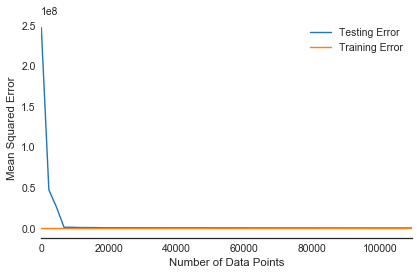

In [236]:
learning_curves(X_train, y_train, X_test, y_test)

## Feature Importance by the Tree Based Model

Mean Squared Error which was the feature selection criteria to measure the quality of the split

In [143]:
# Find the index of most and least important feature and display that column
print("Most important feature = {}".format(X_train.columns[np.argmax(best_model.feature_importances_)]))
print("Least important feature = {}".format(X_train.columns[np.argmin(best_model.feature_importances_)]))

# Get the indices based on feature importance in ascending order 
feature_indices = np.argsort(best_model.feature_importances_)

#print("\nTop 5 most important features:-")
# Reverse the array to get important features at the beginning
#for index in feature_indices[::-1][:5]:
    #print(X_train.columns[index])
    
#print("\nTop 5 least important features:-")
#for index in feature_indices[:5]:
    #print(X_train.columns[index])

Most important feature = T_1
Least important feature = Day


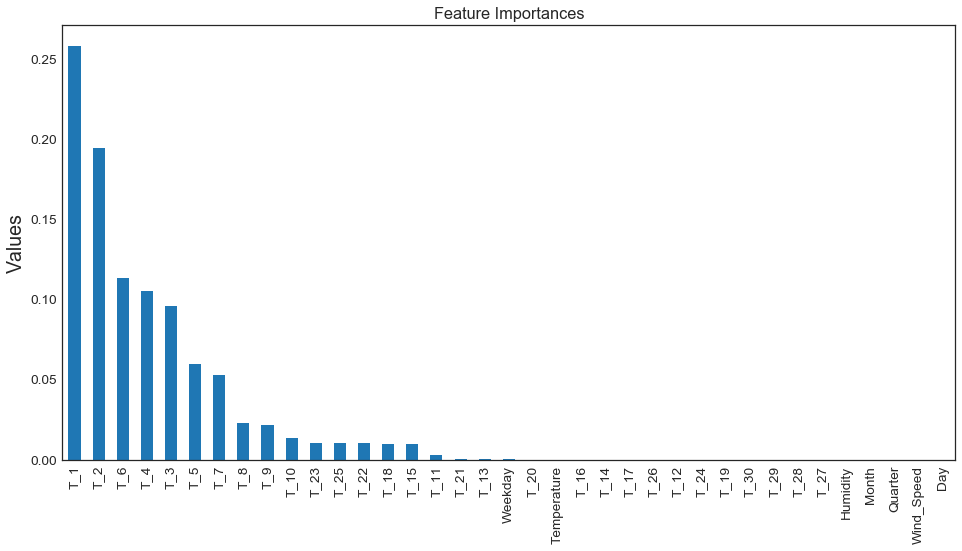

In [144]:
# Plot feature importance
fi = pd.DataFrame(index=X_train.columns[feature_indices], data=np.sort(best_model.feature_importances_))
fi.sort_values(by=0, ascending=False)
fi.head()
# Plot feature importance
fi = pd.DataFrame(index=X_train.columns[feature_indices], data=np.sort(best_model.feature_importances_))
fi.sort_values(by=0, ascending=False, inplace=True)
ax = fi.plot(kind="bar", title="Feature Importances", figsize=(16, 8))
ax.set_ylabel("Values", fontsize="large")
ax.legend_.remove()

# Deep Learning
## LSTM

In [2]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
# load the dataset
dataframe = pd.read_excel('LSTM.xlsx', usecols=[1], skipfooter=3)
dataset = dataframe.values #numpy.ndarray
dataset = dataset.astype('float32')

In [5]:
dataset.shape

(157819, 1)

In [4]:
numpy.random.seed(7)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.69)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

108895 48924


In [8]:
train[108894]

array([0.38522425], dtype=float32)

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
# reshape into X=t and Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [10]:
trainX.shape

(108864, 1, 30)

In [9]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [11]:
from keras.callbacks import EarlyStopping
import time

In [12]:
# create and fit the LSTM network
model = Sequential() # New Instance of Model Object
model.add(LSTM(50, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(72, return_sequences=True)) 
#model.add(LSTM(82, return_sequences=True)) 
#model.add(LSTM(42))
#model.add(Dense(100, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(50, activation='relu'))
#model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.compile(loss='mean_squared_error', optimizer='ADAM')

start = time.time()
hist =model.fit(trainX, trainY, epochs=150, shuffle=True,batch_size=125, validation_data=(testX, testY), 
                callbacks=[EarlyStopping(monitor='val_loss', patience=150)], verbose=1)

end = time.time()
# Training Phase
model.summary()

ValueError: Error when checking target: expected dense_3 to have 3 dimensions, but got array with shape (108864, 1)

In [13]:
# create and fit the LSTM network
model = Sequential() # New Instance of Model Object
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(100, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='ADAM')

start = time.time()
hist =model.fit(trainX, trainY, epochs=150, shuffle=True,batch_size=125, validation_data=(testX, testY), 
                callbacks=[EarlyStopping(monitor='val_loss', patience=30)], verbose=1)

end = time.time()
# Training Phase
model.summary()

Train on 108864 samples, validate on 48893 samples
Epoch 1/150
108864/108864 [==============================] - 3s 26us/step - loss: 0.0024 - val_loss: 2.2078e-04
Epoch 2/150
108864/108864 [==============================] - 2s 16us/step - loss: 2.1404e-04 - val_loss: 1.6915e-04
Epoch 3/150
108864/108864 [==============================] - 2s 16us/step - loss: 1.6618e-04 - val_loss: 1.4804e-04
Epoch 4/150
108864/108864 [==============================] - 2s 16us/step - loss: 1.5609e-04 - val_loss: 2.1941e-04
Epoch 5/150
108864/108864 [==============================] - 2s 16us/step - loss: 1.3820e-04 - val_loss: 1.1650e-04
Epoch 6/150
108864/108864 [==============================] - 2s 19us/step - loss: 1.3350e-04 - val_loss: 1.2514e-04
Epoch 7/150
108864/108864 [==============================] - 2s 18us/step - loss: 1.2248e-04 - val_loss: 9.5138e-05
Epoch 8/150
108864/108864 [==============================] - 2s 17us/step - loss: 1.1234e-04 - val_loss: 9.1918e-05
Epoch 9/150
108864/108864

108864/108864 [==============================] - 2s 15us/step - loss: 2.9811e-05 - val_loss: 4.1126e-05
Epoch 71/150
108864/108864 [==============================] - 2s 17us/step - loss: 3.4284e-05 - val_loss: 3.2111e-05
Epoch 72/150
108864/108864 [==============================] - 2s 15us/step - loss: 2.9509e-05 - val_loss: 2.5855e-05
Epoch 73/150
108864/108864 [==============================] - 2s 16us/step - loss: 2.9608e-05 - val_loss: 4.1038e-05
Epoch 74/150
108864/108864 [==============================] - 2s 14us/step - loss: 3.2233e-05 - val_loss: 2.7078e-05
Epoch 75/150
108864/108864 [==============================] - 2s 16us/step - loss: 3.1100e-05 - val_loss: 3.6773e-05
Epoch 76/150
108864/108864 [==============================] - 2s 15us/step - loss: 3.0364e-05 - val_loss: 3.0124e-05
Epoch 77/150
108864/108864 [==============================] - 2s 15us/step - loss: 2.9547e-05 - val_loss: 4.6547e-05
Epoch 78/150
108864/108864 [==============================] - 2s 17us/step - 

Epoch 140/150
108864/108864 [==============================] - 2s 14us/step - loss: 2.3625e-05 - val_loss: 2.1056e-05
Epoch 141/150
108864/108864 [==============================] - 2s 15us/step - loss: 2.2891e-05 - val_loss: 2.2113e-05
Epoch 142/150
108864/108864 [==============================] - 2s 14us/step - loss: 2.2225e-05 - val_loss: 2.2939e-05
Epoch 143/150
108864/108864 [==============================] - 2s 14us/step - loss: 2.3222e-05 - val_loss: 3.0733e-05
Epoch 144/150
108864/108864 [==============================] - 2s 14us/step - loss: 2.1664e-05 - val_loss: 4.5078e-05
Epoch 145/150
108864/108864 [==============================] - 2s 15us/step - loss: 2.2189e-05 - val_loss: 1.8465e-05
Epoch 146/150
108864/108864 [==============================] - 2s 15us/step - loss: 2.2195e-05 - val_loss: 1.9669e-05
Epoch 147/150
108864/108864 [==============================] - 2s 15us/step - loss: 2.2695e-05 - val_loss: 2.0040e-05
Epoch 148/150
108864/108864 [===========================

In [24]:
b=testY[:96]
b.shape

(96,)

In [25]:
print ("Model took %0.2f seconds to train"%(end - start))

Model took 829.35 seconds to train


In [72]:
logger=keras.callbacks.TensorBoard(log_dir='logs', write_graph=True)

In [14]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [15]:
from sklearn.metrics import mean_absolute_error

In [16]:
print('Mean Absolute Error Test:', mean_absolute_error(y_actual, y_predict))
print('Mean Squared Error Test:',np.sqrt(mean_squared_error(y_actual, y_predict)))
#print('Mean Absolute Percentage Error:',MAPError(testY[0], testPredict[:,0]))

NameError: name 'y_actual' is not defined

In [17]:
print('Mean Absolute Error Test:', mean_absolute_error(testY[0], testPredict[:,0]))
print('Mean Squared Error Test:',np.sqrt(mean_squared_error(testY[0], testPredict[:,0])))
#print('Mean Absolute Percentage Error:',MAPError(testY[0], testPredict[:,0]))

Mean Absolute Error Test: 228.25948552028896
Mean Squared Error Test: 316.0586183786099


In [18]:
print('Mean Absolute Error Train:', mean_absolute_error(trainY[0], trainPredict[:,0]))
print('Mean Squared Error Train:',np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])))
#print('Mean Absolute Percentage Error:',MAPError(trainY[0], trainPredict[:,0]))


print('Mean Absolute Error Test:', mean_absolute_error(testY[0], testPredict[:,0]))
print('Mean Squared Error Test:',np.sqrt(mean_squared_error(testY[0], testPredict[:,0])))
#print('Mean Absolute Percentage Error:',MAPError(testY[0], testPredict[:,0]))

Mean Absolute Error Train: 220.76364668387757
Mean Squared Error Train: 305.08240701436154
Mean Absolute Error Test: 228.25948552028896
Mean Squared Error Test: 316.0586183786099


In [40]:
type(hist.history['loss'])

list

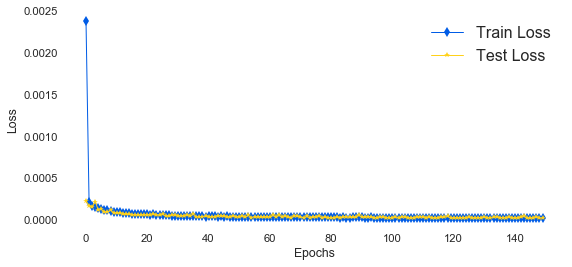

In [122]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.4)  
plt.figure(figsize=(9,4))
import matplotlib as mpl
#mpl.rcParams['legend.frameon'] = 'True'
plt.plot(hist.history['loss'], color='#005ce6', linewidth=1, marker='d', markersize=7, label='Train Loss')
plt.plot(hist.history['val_loss'], color='#ffd11a',linewidth=1, marker='*',markersize=6, label='Test Loss')
plt.tick_params(left=False, labelleft=True) #remove ticks
plt.box(False)
plt.xlabel('Epochs')
plt.ylabel('Loss')
legend = plt.legend(loc='upper right',prop={'size': 16})
#legend.get_frame().set_facecolor('#8c8c8c')
plt.savefig('Fig15.4.png', dpi=400)

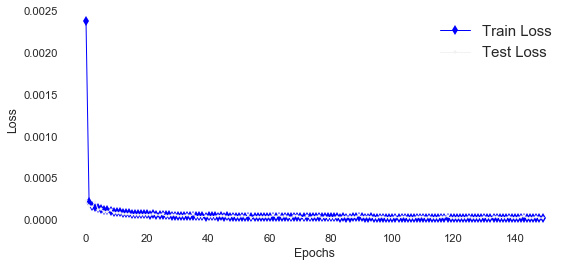

In [119]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.4)  
plt.figure(figsize=(9,4))
frame = legend.get_frame()
frame.set_color('white')

plt.plot(hist.history['loss'], color='#0000ff', linewidth=1, marker='d', markersize=7, label='Train Loss')
plt.plot(hist.history['val_loss'], color='#f2f2f2',linewidth=1, marker='*',markersize=5, label='Test Loss')
plt.tick_params(left=False, labelleft=True) #remove ticks
plt.box(False)
plt.xlabel('Epochs')
plt.ylabel('Loss')
legend = plt.legend(frameon = 1)
plt.legend(loc='best',prop={'size': 15});
frame.set_facecolor('blue')
frame.set_edgecolor('red')
plt.savefig('Fig15.4.png', dpi=400)

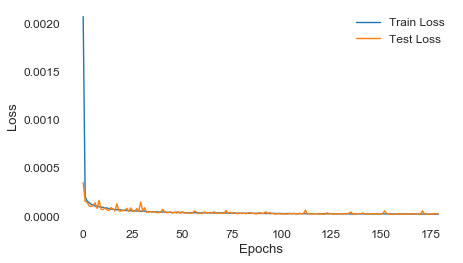

In [163]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.5)  
plt.figure(figsize=(8,4))

plt.plot(hist.history['loss'], marker='s', markersize=12, label='Train Loss')
plt.plot(hist.history['val_loss'], marker='*',markersize=12, label='Test Loss')
plt.tick_params(left=False, labelleft=True) #remove ticks
plt.box(False)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right');
plt.legend()
#plt.savefig('Fig8.png', dpi=300)

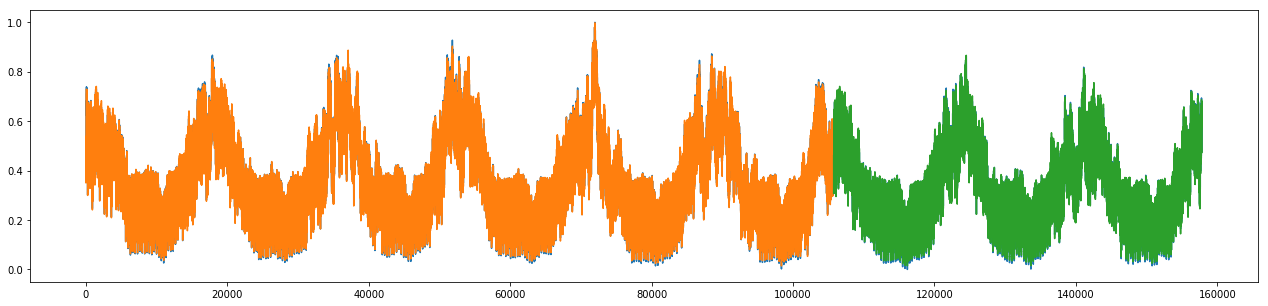

In [40]:
# plot baseline and predictions
plt.figure(figsize=(22,5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [24]:
trainPredict1=pd.DataFrame(trainPredict)
trainY1=pd.DataFrame(trainY)
trainY1=trainY1.transpose()

testPredict1=pd.DataFrame(testPredict)
testY1=pd.DataFrame(testY)
testY1=testY1.transpose()

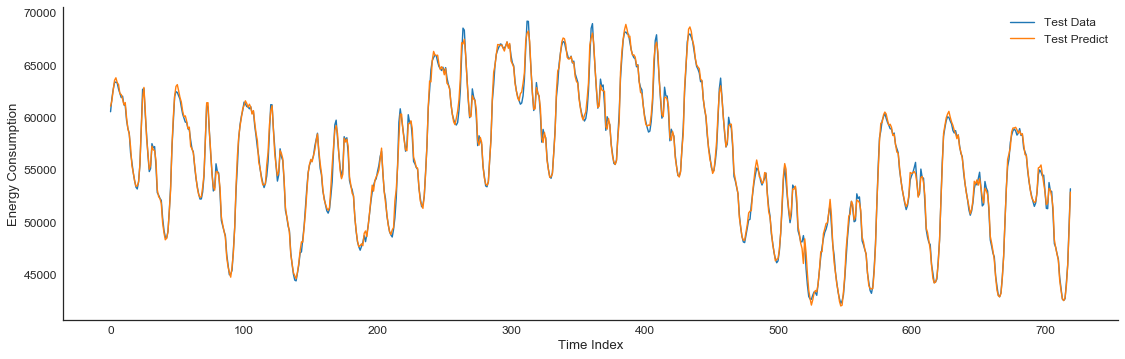

In [26]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.5)  
plt.figure(figsize=(16,5))
plt.plot(testY1[:720], label = "Test Data")
plt.plot(testPredict1[:720], label = "Test Predict")
plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.xlabel('Time Index')
plt.ylabel('Energy Consumption')
plt.legend(loc='upper right');
plt.savefig('Fig8.png', dpi=500)

In [ ]:
    df.MAE_ExtraTrees.plot(color='#ff8080',linewidth=2, marker='s',markersize=6)
    df.MAE_LSTM.plot(color='#cc0000',linewidth=2, marker='o',markersize=6)
    df.RMSE_ExtraTrees.plot(color='#80b3ff',linewidth=2, marker='s',markersize=6)
    df.RMSE_LSTM.plot(color='#0047b3',linewidth=2, marker='o',markersize=6)

## TIME SERIES SPLIT METHOD

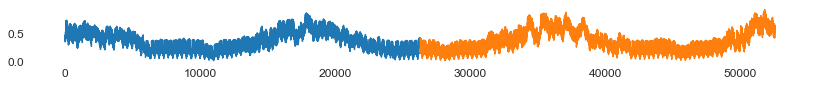

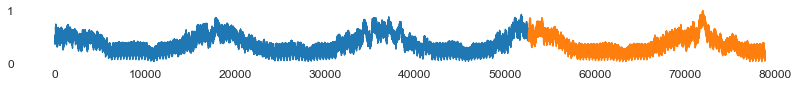

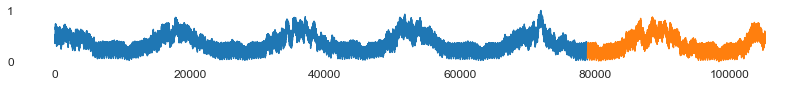

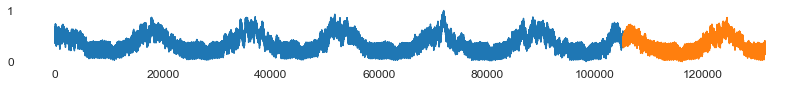

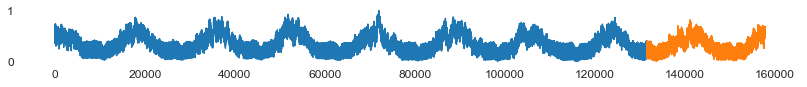

In [171]:
from sklearn.model_selection import TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=5)
plt.figure(1)

index = 1
for train_index, test_index in splits.split(dataset):
	train = dataset[train_index]
	test = dataset[test_index]
	#print('Observations: %d' % (len(train) + len(test)))
	#print('Training Observations: %d' % (len(train)))
	#print('Testing Observations: %d' % (len(test)))
	plt.figure(figsize=(14,6))  
	sns.set_style('white')
	sns.set_context("paper", font_scale=1.5)  
    
    
	plt.subplot(510 + index)
	plt.plot(train)
	plt.plot([None for i in train] + [x for x in test])
	index += 1
	plt.xlabel('')
	plt.tick_params(left=False, labelleft=True) #remove ticks
	plt.box(False)
plt.show();

In [146]:
dataset1=dataset[:157819]

In [147]:
dataset1.shape

(157819, 1)

In [149]:
# split into train and test sets
train_size = int(len(dataset1) * 0.83)
test_size = len(dataset1) - train_size
train, test = dataset1[0:train_size,:], dataset1[train_size:len(dataset),:]
print(len(train), len(test))

130989 26830


In [150]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [69]:
# reshape into X=t and Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


from keras.callbacks import EarlyStopping
import time


# create and fit the LSTM network
model = Sequential() # New Instance of Model Object
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(100, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='ADAM')

start = time.time()
hist =model.fit(trainX, trainY, epochs=180, shuffle=True,batch_size=125, validation_data=(testX, testY), 
                callbacks=[EarlyStopping(monitor='val_loss', patience=30)], verbose=1)

end = time.time()
# Training Phase
model.summary()

print ("Model took %0.2f seconds to train"%(end - start))

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

print('Mean Absolute Error Train:', mean_absolute_error(trainY[0], trainPredict[:,0]))
print('Mean Squared Error Train:',np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])))
#print('Mean Absolute Percentage Error:',MAPError(trainY[0], trainPredict[:,0]))


print('Mean Absolute Error Test:', mean_absolute_error(testY[0], testPredict[:,0]))
print('Mean Squared Error Test:',np.sqrt(mean_squared_error(testY[0], testPredict[:,0])))
#print('Mean Absolute Percentage Error:',MAPError(testY[0], testPredict[:,0]))


Train on 108864 samples, validate on 65 samples
Epoch 1/180
108864/108864 [==============================] - 2s 23us/step - loss: 0.0021 - val_loss: 4.5479e-04
Epoch 2/180
108864/108864 [==============================] - 2s 14us/step - loss: 2.1352e-04 - val_loss: 2.1798e-04
Epoch 3/180
108864/108864 [==============================] - 2s 14us/step - loss: 1.6177e-04 - val_loss: 2.0033e-04
Epoch 4/180
108864/108864 [==============================] - 2s 15us/step - loss: 1.4241e-04 - val_loss: 1.4649e-04
Epoch 5/180
108864/108864 [==============================] - 2s 15us/step - loss: 1.2897e-04 - val_loss: 9.0765e-05
Epoch 6/180
108864/108864 [==============================] - 2s 15us/step - loss: 1.2088e-04 - val_loss: 9.4820e-05
Epoch 7/180
108864/108864 [==============================] - 2s 15us/step - loss: 1.1177e-04 - val_loss: 1.2642e-04
Epoch 8/180
108864/108864 [==============================] - 2s 15us/step - loss: 1.0773e-04 - val_loss: 1.0479e-04
Epoch 9/180
108864/108864 [=

NameError: name 'mean_absolute_error' is not defined

In [16]:
df=df.set_index('Folds')

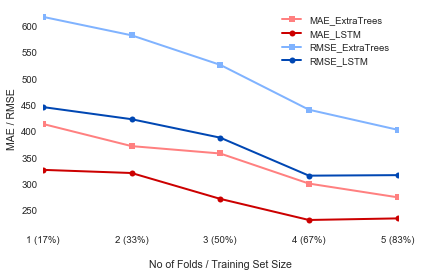

In [58]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.2)  


with pd.plot_params.use('x_compat', True):
    df.MAE_ExtraTrees.plot(color='#ff8080',linewidth=2, marker='s',markersize=6)
    df.MAE_LSTM.plot(color='#cc0000',linewidth=2, marker='o',markersize=6)
    df.RMSE_ExtraTrees.plot(color='#80b3ff',linewidth=2, marker='s',markersize=6)
    df.RMSE_LSTM.plot(color='#0047b3',linewidth=2, marker='o',markersize=6)

#df.plot(x='Folds',linewidth=2, marker='o',markersize=5)
#plt.xticks(np.arange(min(df.Folds), max(df.Folds)+1, 1.0))
plt.xticks([0, 1, 2, 3, 4], ['1 (17%)', '2 (33%)', '3 (50%)','4 (67%)','5 (83%)'])
#plt.tick_params(left=True, labelleft=True) #remove ticks
plt.box(False)
#plt.margins(0.2)
plt.xlabel('No of Folds / Training Set Size',labelpad=15)
plt.ylabel('MAE / RMSE')
plt.legend(loc='upper right');
plt.tight_layout()
plt.savefig('Fig9.png', dpi=300)

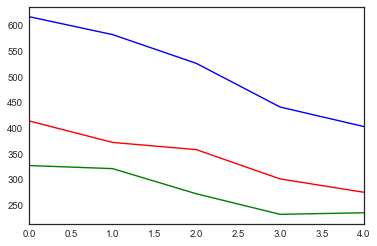

In [37]:
plt.figure()


with pd.plot_params.use('x_compat', True):
    df.MAE_ExtraTrees.plot(color='r')
    df.MAE_LSTM.plot(color='g')
    df.RMSE_ExtraTrees.plot(color='b')

### Horizon Validation

In [28]:
# split into train and test sets
train_size = int(len(dataset) * 0.69)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

108895 48924


In [65]:
dataset1=dataset[:157819]

In [68]:
# Very Short Term
train_size = int(len(dataset1) * 0.69)
test_size = dataset1[108895:108991]
train, test = dataset1[0:train_size,:], test_size
print(len(train), len(test))

108895 96


In [53]:
# Short Term
train_size = int(len(dataset1) * 0.69)
test_size = dataset1[108943:109615]
train, test = dataset1[0:train_size,:], test_size
print(len(train), len(test))

108895 672


In [56]:
# Medium Term
train_size = int(len(dataset1) * 0.69)
test_size = dataset1[109231:112111]
train, test = dataset1[0:train_size,:], test_size
print(len(train), len(test))

108895 2880
